In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
# import mplfinance as mpf
import yfinance as yf
import pickle
from datetime import date, timedelta, datetime
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

In [4]:
tlist={}

def cleanup_history(ticker, wkly, mly):
    df = wkly[ticker]
    wkly[ticker] = df[(df.index.map(lambda x: x.weekday())==0)] ## keep first day of week
    df = mly[ticker]
    mly[ticker] = df[df.index.map(lambda x: x.day)==1] ## keep first day of month

    
# def load_stock():
#     '''Load data (deserialize)'''
#     dly = pickle.load(open('stock_dly.pickle', 'rb'))
#     wkly = pickle.load(open('stock_wkly.pickle', 'rb'))
#     mly = pickle.load(open('stock_mly.pickle', 'rb'))
#     info = pickle.load(open('stock_info.pickle', 'rb'))
#     return (dly, wkly, mly, info)
#     return (dly, info)


def load_stock():
    '''Load data (deserialize)'''
    final_dict={}
    num = 10
    for i in range(num):
        temp_dict = pickle.load(open('stock_dly'+str(i)+'.pickle', 'rb'))
        final_dict.update(temp_dict)
    dly = final_dict
    
    info = pickle.load(open('stock_info.pickle', 'rb'))
    return (dly, info)


# def download_all(tickers_set, dly, wkly, mly, info):
#     for ticker in tickers_set:
#         t = yf.Ticker(ticker)
#         dly[ticker] = t.history(period='max', interval='1d').dropna()
#         wkly[ticker] = t.history(period='2y', interval='1wk').dropna()
#         mly[ticker] = t.history(period='max', interval='1mo').dropna()
#         info[ticker] = t.info
#         print('{} downloaded'.format(ticker))
        
# def download_recent(tickers_set, dly, wkly, mly):
#     for ticker in tickers_set:
#         t = yf.Ticker(ticker)
#         d_new = t.history(period='max', interval='1d').dropna()
#         d_new = t.history(period='1mo', interval='1d').dropna()
#         w_new = t.history(period='3mo', interval='1wk').dropna()
#         m_new = t.history(period='3mo', interval='1mo').dropna()
#         if d_new.size>0:
#             d_new.index = d_new.index.date
#             dly[ticker] = d_new.combine_first(dly[ticker])
#         d_new.index = d_new.index.map(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S-05:00'))
#         w_new.index = w_new.index.map(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S-05:00'))
#         m_new.index = m_new.index.map(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S-05:00'))        
#         wkly[ticker] = w_new.combine_first(wkly[ticker])
#         mly[ticker] = m_new.combine_first(mly[ticker])
#         cleanup_history(ticker, wkly, mly)

def download_all(tickers_set, dly):
    for ticker in tickers_set:
        t = yf.Ticker(ticker)
        dly[ticker] = t.history(period='max', interval='1d').dropna()
        print('{} downloaded'.format(ticker))

def download_recent(tickers_set, dly):
    for ticker in tickers_set:
        t = yf.Ticker(ticker)
        d_new = t.history(period='1mo', interval='1d').dropna()
        if d_new.size>0:
            d_new.index = d_new.index.date
            dly[ticker] = d_new.combine_first(dly[ticker])
            dly[ticker].index.name='Date'
        
def update(tickers_set, dly):
    i = 0
    for ticker in tickers_set:
        print(ticker)
        i=i+1
        download_recent([ticker], dly) if ticker in dly else download_all([ticker], dly)
        print('{}. {} updated'.format(i, ticker))

# def update(tickers_set, dly, wkly, mly, info):
#     i = 0
#     for ticker in tickers_set:
#         print(ticker)
#         i=i+1
#         download_recent([ticker], dly, wkly, mly) if ticker in dly else download_all([ticker], dly, wkly, mly, info)
#         print('{}. {} updated'.format(i, ticker))
        
def update_info(tickers_set, info):
    i = 0
    for ticker in tickers_set:
        t = yf.Ticker(ticker)
        info[ticker] = t.info
        i=i+1
        print('{}. {} updated'.format(i, ticker))

def archive_stock():
    # Store data (serialize)
    pickle.dump(dly, open('stock_dly.pickle', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(wkly, open('stock_wkly.pickle', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(mly, open('stock_mly.pickle', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(info, open('stock_info.pickle', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

def archive_stock_dly():
    '''Store dly dictionary (serialize)'''
    pickle.dump(dly, open('stock_dly.pickle', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

def archive_stock_dly():
    '''Store dly dictionary in 10 pickle files'''
    keys = list(dly.keys())
    num = 10
    chunk = int(len(keys)/num)+1
    for i in range(num):
        ind=i+1
        temp_keys=keys[(ind-1)*chunk:ind*chunk]
        temp_dict = {k:dly[k] for k in temp_keys}
        pickle.dump(temp_dict, open('stock_dly'+str(i)+'.pickle', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)


In [5]:
# load dataframes from archive
(dly, info) = load_stock()

In [15]:
def get_tsx_list():
    import requests 

    html_dict = {}
    for letter in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ':
        s = requests.Session() 
        s.headers['User-Agent'] = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/34.0.1847.116 Chrome/34.0.1847.116 Safari/537.36' 
        url = 'http://eoddata.com/stocklist/TSX/' + letter + '.htm' 
        r = s.get(url) 
        s.close()
        html_dict[letter] = pd.read_html(r.text, flavor='bs4') 

    df = html_dict['A'][4][['Code','Name','High','Low','Close','Volume']].set_index('Code')
    for key in html_dict:
        df = pd.concat( [df, html_dict[key][4][['Code','Name','High','Low','Close','Volume']].set_index('Code') ])
    df = df.drop_duplicates()
    pickle.dump(df, open('stock_tsx_list.pickle', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
# get_tsx_list()

def get_tsx_df():
    tsx_list = pickle.load(open('stock_tsx_list.pickle', 'rb')).reset_index()

    df = tsx_list.where(tsx_list.Close>1).where(tsx_list.Volume>=100000).dropna()
    df.Code=df.Code.apply(lambda x: x if x==x else 'NA')
    df = df[~df.Code.str.contains('\.DB')]
    df = df[df.Code.apply(lambda x: x.find('.')==x.rfind('.'))]
    df['Code2'] = df.Code.apply(lambda x: '{}.TO'.format(x.replace('.','-')))
    df['volprice']=df.Volume*df.Close
    df = df[df.volprice>=2000000]
    df_tokeep = df.sort_values(by=['volprice'], ascending=False)
    codes_tokeep = [x for x in df_tokeep.Code2.to_list() if x != 'IPL.TO']
    missed_codes=['NA.TO']
    codes_tokeep = codes_tokeep + missed_codes
    

    df = pd.DataFrame.from_dict({'sector': 'Industrials', 'industry': 'Railroads', 'shortName': 'CANADIAN PACIFIC RAILWAY LIMITE', 'symbol': 'CP.TO'}, orient='index').T.set_index('symbol')
    df.drop(index='CP.TO', inplace=True)

    for t in codes_tokeep:
        d = {}
        for k in ['sector', 'industry', 'shortName', 'symbol']:
            d[k] = info[t][k] if k in info[t] else 'ETF'
        df=pd.concat([df, pd.DataFrame.from_dict(d, orient='index').T.set_index('symbol')])
    return df.drop_duplicates().reset_index()
ticks_df = get_tsx_df()

ticks_df = ticks_df[ticks_df.symbol!='ETF']

print(ticks_df.__len__())
print(ticks_df[['sector','industry']].sort_values(by=['sector','industry']).value_counts(sort=False))

for k in ['Industrials', 'Financial Services', 'Basic Materials', 'Consumer Cyclical', 'Consumer Defensive', 'Utilities', 'Energy', 'Communication Services', 'Technology', 'ETF', 'Healthcare', 'Real Estate']:
#     print(k)
    tlist[k] = ticks_df[ticks_df.sector==k].sort_values(by='industry').symbol.to_list()


l=[]
for i in tlist:
    l = l + tlist[i]
tickers_set = set(l) # unique tickers
delisted = ['IPL.TO','ETF','VFF.TO','KL.TO','XBC.TO', 'ATA.TO', 'TRQ.TO', 'HDI.TO', 'CUF-UN.TO', 'VOYG.TO', 'PVG.TO', 'BAM-A.TO', 'ITP.TO']
tickers_set = [w for w in tickers_set if w not in delisted];

292
sector                  industry                              
                                                                   2
Basic Materials         Agricultural Inputs                        1
                        Chemicals                                  2
                        Copper                                     7
                        Gold                                      29
                        Lumber & Wood Production                   4
                        Other Industrial Metals & Mining           3
                        Other Precious Metals & Mining             4
                        Paper & Paper Products                     1
                        Silver                                     4
                        Specialty Chemicals                        1
                        Steel                                      3
Communication Services  Electronic Gaming & Multimedia             1
                        Entertainmen

In [59]:
# pull latest daily info, append to existing daily data
update(tickers_set, dly)

# update_info(['NA.TO'], info)
# update_info(tickers_set, info)
# download_all(['NA.TO'], dly, wkly, mly, info)
# archive_stock()

AC.TO
1. AC.TO updated
TXG.TO
2. TXG.TO updated
X.TO
3. X.TO updated
POW.TO
4. POW.TO updated
NGD.TO
5. NGD.TO updated
MAXR.TO
6. MAXR.TO updated
XSH.TO
7. XSH.TO updated
IAG.TO
8. IAG.TO updated
LEV.TO
9. LEV.TO updated
CS.TO
10. CS.TO updated
CNQ.TO
11. CNQ.TO updated
DF.TO
12. DF.TO updated
TCW.TO
13. TCW.TO updated
FCR-UN.TO
14. FCR-UN.TO updated
TECK-B.TO
15. TECK-B.TO updated
FR.TO
16. FR.TO updated
GGD.TO
17. GGD.TO updated
GOOS.TO
18. GOOS.TO updated
MFI.TO
19. MFI.TO updated
H.TO
20. H.TO updated
CJ.TO
21. CJ.TO updated
ETHH-U.TO
22. ETHH-U.TO updated
XEG.TO
23. XEG.TO updated
VSP.TO
24. VSP.TO updated
EIT-UN.TO
25. EIT-UN.TO updated
BEPC.TO
26. BEPC.TO updated
VCN.TO
27. VCN.TO updated
DNTL.TO
28. DNTL.TO updated
MRU.TO
29. MRU.TO updated
BOS.TO
30. BOS.TO updated
FTS.TO
31. FTS.TO updated
EMA.TO
32. EMA.TO updated
ATH.TO
33. ATH.TO updated
HND.TO
34. HND.TO updated
EFR.TO
35. EFR.TO updated
ALA.TO
36. ALA.TO updated
ATZ.TO
37. ATZ.TO updated
CCL-B.TO
38. CCL-B.TO updated
SLS

In [70]:
# check date ranges of each stock
[(t, dly[t].index.size, str(dly[t].index[0]).replace(' 00:00:00',''), str(dly[t].index[-1]).replace(' 00:00:00','')) for t in tickers_set if dly[t].index.size>0]
# [(t, dly[t].index.size, str(dly[t].index[0]).replace(' 00:00:00',''), str(dly[t].index[-1]).replace(' 00:00:00','')) for t in dly.keys() if dly[t].index.size>0]

[('BEPC.TO', 657, '2020-07-24', '2023-03-08'),
 ('EMP-A.TO', 7075, '1995-01-12', '2023-03-08'),
 ('PSK.TO', 2202, '2014-05-29', '2023-03-08'),
 ('KEL.TO', 2514, '2013-03-01', '2023-03-08'),
 ('HWX.TO', 6338, '1997-12-11', '2023-03-08'),
 ('VAB.TO', 2791, '2012-01-24', '2023-03-08'),
 ('WCN.TO', 5241, '2002-04-25', '2023-03-08'),
 ('SAP.TO', 6373, '1997-10-24', '2023-03-08'),
 ('EBIT.TO', 514, '2021-02-19', '2023-03-08'),
 ('RY.TO', 7166, '1995-01-12', '2023-03-08'),
 ('SHOP.TO', 1957, '2015-05-21', '2023-03-08'),
 ('ETHH-U.TO', 474, '2021-04-19', '2023-03-08'),
 ('VCN.TO', 2401, '2013-08-13', '2023-03-08'),
 ('HND.TO', 3800, '2008-01-16', '2023-03-08'),
 ('OTEX.TO', 6202, '1998-06-29', '2023-03-08'),
 ('SMU-UN.TO', 3520, '2009-02-09', '2023-02-17'),
 ('CMMC.TO', 3936, '2007-06-29', '2023-03-08'),
 ('GGD.TO', 3229, '2010-04-22', '2023-03-08'),
 ('HUV.TO', 3063, '2010-12-21', '2023-03-08'),
 ('FR.TO', 6678, '1996-08-08', '2023-03-08'),
 ('XEG.TO', 5513, '2001-03-23', '2023-03-08'),
 ('CM

In [61]:
# save dly dictionary to disk
archive_stock_dly()

In [62]:
def dly2mly(df_dly):
    '''
    input daily table, return monthly table, index by month end
    '''
    h2 = df_dly.copy()
    # convert index from datetimestamp to monthend date
    h2.index = h2.index.to_period('M').to_timestamp('M')
    s_divs = h2.Dividends.groupby(by='Date').max() # max returns dividend or 0 if none in this month
    s_open = h2.Open.groupby(by='Date').first()    # first Open tick in the month
    s_close = h2.Close.groupby(by='Date').last()   # last Close tick in the month
    s_high = h2.High.groupby(by='Date').max()
    s_low = h2.Low.groupby(by='Date').min()
    s_volume = h2.Volume.groupby(by='Date').sum()  # sum of all daily volumes in the month
    df_mly = pd.concat([s_open, s_close, s_high, s_low, s_volume, s_divs], axis=1)
    return(df_mly)

In [63]:
def get_div(mly_df):
    '''
    input monthly dataframe, output yearly dividend based on the last dividend and time period since previous dividend
    '''
    div_df=mly_df[mly_df.Dividends>0]
    if div_df.size==0: return 0
    div_delta=div_df.index.to_series().diff()[-1].days # difference in days between the last two dividend dates
    return(div_df.Dividends[-1] / div_delta * 365)

In [65]:
# convert index from date to datetime
for t in dly.keys():
    if dly[t].size>0:
        x=dly[t].index[0]
        if not isinstance(x, dt.datetime):
            dly[t].index=pd.to_datetime(dly[t].index)

In [66]:
# create mly dictionary from dly
mly={}
for t in tickers_set:
    print(t, end=' ')
    mly[t]=dly2mly(dly[t])

AC.TO TXG.TO X.TO POW.TO NGD.TO MAXR.TO XSH.TO IAG.TO LEV.TO CS.TO CNQ.TO DF.TO TCW.TO FCR-UN.TO TECK-B.TO FR.TO GGD.TO GOOS.TO MFI.TO H.TO CJ.TO ETHH-U.TO XEG.TO VSP.TO EIT-UN.TO BEPC.TO VCN.TO DNTL.TO MRU.TO BOS.TO FTS.TO EMA.TO ATH.TO HND.TO EFR.TO ALA.TO ATZ.TO CCL-B.TO SLS.TO NTR.TO DLR.TO BTCX-B.TO QSR.TO OGI.TO AP-UN.TO ZWB.TO WN.TO ERO.TO AR.TO GWO.TO HWX.TO DOL.TO WCP.TO VAB.TO TLRY.TO BITI.TO CHP-UN.TO HUV.TO ECN.TO AT.TO VDY.TO NGT.TO CHR.TO SAP.TO BLDP.TO ETHH.TO STN.TO BIP-UN.TO CGX.TO GFL.TO TSU.TO FEC.TO XBB.TO YRI.TO CARE.TO LB.TO STLC.TO SJR-B.TO CPX.TO EMP-A.TO BMO.TO FVI.TO ACO-X.TO WEED.TO BTE.TO CF.TO GIB-A.TO CAE.TO TOU.TO REAL.TO CU.TO RNW.TO BLX.TO ZWU.TO ZEB.TO HNU.TO IMO.TO ETHX-U.TO BIPC.TO KRR.TO OLA.TO DPM.TO IFP.TO MTL.TO PAAS.TO TVE.TO BIR.TO HPR.TO CSH-UN.TO WDO.TO CMMC.TO TCN.TO FOOD.TO HR-UN.TO DND.TO EDR.TO PKI.TO AYA.TO ACB.TO SNC.TO CCO.TO EQX.TO ABX.TO CP.TO FSZ.TO OGC.TO K.TO OBE.TO OVV.TO WEF.TO CIX.TO AEM.TO MEG.TO PSK.TO SES.TO CTS.TO IIP-UN.TO

In [24]:
ticker='CP.TO'
t = yf.Ticker(ticker)
# t.fast_info
{k:t.fast_info[k] for k in t.fast_info.keys()}

In [67]:
def get_value(x): return float(x) if x is not None else 0.0
def get_dt(x): return (date(1970, 1, 1) + timedelta(seconds=x) - timedelta(days=1)).strftime('%b%d') if x is not None else '-'
def get_dt2(x): return (date(1970, 1, 1) + timedelta(seconds=x) - timedelta(days=1)) if x is not None else 0
def get_if(dict, key): return dict[key] if key in dict else None

def get_title(ticker):
    str = ticker + ' ({}:'.format(get_if(info[ticker],'shortName'))
    str += ' {}):    '.format(get_if(info[ticker], 'industry'))
    str += ' Clse: {:.2f} '.format(get_value(dly[ticker][-1:]['Close'].to_list()[0]))
    str += '| Div: {:.1%} '.format(get_div(mly[ticker])/100)
#     str += '| Tgt: {} '.format(get_value(get_if(info[ticker], 'targetMedianPrice')))
#     str += '| Inst: {:.0%} '.format(get_value(get_if(info[ticker],'heldPercentInstitutions')))
#     str += '| Div: {:.1%} '.format(get_value(get_if(info[ticker],'dividendYield')))
#     str += '| Payout: {:.1%} '.format(get_value(get_if(info[ticker],'payoutRatio')))
#     str += '| EPS: {:.1f} '.format(get_value(get_if(info[ticker],'trailingEps')))
#     str += '| QErngYoY: {:.1%} '.format(get_value(get_if(info[ticker],'earningsQuarterlyGrowth')))
#     str += '| RoA: {:.1%} '.format(get_value(get_if(info[ticker],'returnOnAssets')))
#     str += '| RoE: {:.1%} '.format(get_value(get_if(info[ticker],'returnOnEquity')))
#     str += '| Shrt: {:.2%} -> {:.2%}  ({} -> {})'.format(get_if(info[ticker],'sharesShortPriorMonth')/
#                                                          get_if(info[ticker],'sharesOutstanding') if get_if(info[ticker],'sharesShortPriorMonth') is not None and get_if(info[ticker],'sharesOutstanding') is not None else 0.0, 
#                                                          get_if(info[ticker],'sharesShort')/
#                                                          get_if(info[ticker],'sharesOutstanding') if get_if(info[ticker],'sharesShort') is not None and get_if(info[ticker],'sharesOutstanding') is not None else 0.0,  
#                                                          get_dt(get_if(info[ticker],'sharesShortPreviousMonthDate')), 
#                                                          get_dt(get_if(info[ticker],'dateShortInterest')))
    return str
# get_title('XIU.TO')

In [68]:
def get_sma(prices, rate=20):
    return prices.rolling(rate).mean()
def get_std(prices, rate=20):
    return prices.rolling(rate).std()
def get_bol_upper(prices, rate=20):
    return get_sma(prices, rate) + get_std(prices, rate)*2
def get_bol_lower(prices, rate=20):
    return get_sma(prices, rate) - get_std(prices, rate)*2
def get_rsi(price, n=15):
    close = price.Low
    delta = close.diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ema_up = up.ewm(com=n, adjust=False).mean()
    ema_down = down.ewm(com=n, adjust=False).mean()
    rs = ema_up/ema_down
    rsi = 100 - 100/(1+rs)
    return rsi
# get_rsi(dly['TD.TO'].Close, 15)

In [69]:
book = {}
book['ARE.TO']=[16.77]
book['MTL.TO']=[12.08]
book['BCE.TO']=[54.58]
book['QSR.TO']=[87.16]
# book['RCI-B.TO']=[63.89]
book['ENB.TO']=[48.80]
# book['SAP.TO']=[29.05]
# book['CJR-B.TO']=[4.63]
# book['CCA.TO']=[99.47]
book['AEM.TO']=[62.86]
book['AR.TO']=[2.34]


In [70]:
# combine tickers into one reference dataframe
tick_groups = {}
tick_groups['banks'] = ticks_df[ticks_df.industry.str.contains('Bank')].symbol.tolist()
tick_groups['capital'] = ticks_df[ticks_df.industry.str.contains('Capital Markets')].symbol.tolist()
tick_groups['asset'] = ticks_df[ticks_df.industry.str.contains('Asset Management')].symbol.tolist()
tick_groups['insurance'] = ticks_df[ticks_df.industry.str.contains('Ins')].symbol.tolist()
tick_groups['gold'] = ticks_df[ticks_df.industry.str.contains('Gold')].symbol.tolist()
tick_groups['silver'] = ticks_df[ticks_df.industry.str.contains('Silver')].symbol.tolist()
tick_groups['chemicals'] = ticks_df[ticks_df.industry.str.contains('Chemicals')].symbol.tolist()
tick_groups['copper'] = ticks_df[ticks_df.industry.str.contains('Copper')].symbol.tolist()
tick_groups['metals'] = ticks_df[ticks_df.industry.str.contains('Metals')].symbol.tolist()
tick_groups['steel'] = ticks_df[ticks_df.industry.str.contains('Steel')].symbol.tolist()
tick_groups['lumber'] = ticks_df[ticks_df.industry.str.contains('Lumber')].symbol.tolist()
tick_groups['telecom'] = ticks_df[ticks_df.industry.str.contains('Telecom')].symbol.tolist()
tick_groups['stores'] = ticks_df[ticks_df.industry.str.contains('Stores')].symbol.tolist()
tick_groups['Engineering'] = ticks_df[ticks_df.industry.str.contains('Engin')].symbol.tolist()
tick_groups['waste'] = ticks_df[ticks_df.industry.str.contains('Waste')].symbol.tolist()
tick_groups['Midstream'] = ticks_df[ticks_df.industry.str.contains('Midstream')].symbol.tolist()
tick_groups['E&P'] = ticks_df[ticks_df.industry.str.contains('E&P')].symbol.tolist()
tick_groups['power'] = ticks_df[ticks_df.industry.str.contains('Electric')].symbol.tolist() + ticks_df[ticks_df.industry.str.contains('Power')].symbol.tolist()
tick_groups['renewable'] = ticks_df[ticks_df.industry.str.contains('Renewable')].symbol.tolist()
tick_groups['Utilities—Regulated Gas'] = ticks_df[ticks_df.industry.str.contains('Utilities—Regulated Gas')].symbol.tolist()
tick_groups['uranium'] = ticks_df[ticks_df.industry.str.contains('Uranium')].symbol.tolist()
tick_groups['REIT'] = ticks_df[ticks_df.industry.str.contains('REIT')].symbol.tolist() + ticks_df[ticks_df.industry.str.contains('Real Estate')].symbol.tolist()
tick_groups['Software'] = ticks_df[ticks_df.industry.str.contains('Software')].symbol.tolist() + ticks_df[ticks_df.industry.str.contains('Information')].symbol.tolist()
tick_groups['Drug'] = ticks_df[ticks_df.industry.str.contains('Drug')].symbol.tolist()
tick_groups['Aero'] = ticks_df[ticks_df.industry.str.contains('Air')].symbol.tolist() + ticks_df[ticks_df.industry.str.contains('Aero')].symbol.tolist()
tick_groups['Rail'] = ticks_df[ticks_df.industry.str.contains('Railroads')].symbol.tolist()
tick_groups['Machinery'] = ticks_df[ticks_df.industry.str.contains('Machinery')].symbol.tolist()
tick_groups['Grocery'] = ticks_df[ticks_df.industry.str.contains('Grocery')].symbol.tolist()
tick_groups['ETF'] = ticks_df[ticks_df.industry.str.contains('ETF')].symbol.tolist()

def get_aggr(ticker, df, l, tick_groups):
    key = [k for k in tick_groups if ticker in tick_groups[k]][0]
    g = [i for i in tick_groups[key] if i != ticker and i in tickers_set]

    l = min(l, len(df[ticker]))
    wt = sum([info[d]['marketCap'] for d in g])
    price_ref = df[ticker].Close.iloc[-int(l)]
    aggr_price_ref = sum( [(df[d].Close.iloc[-int(l)] if len(df[d])>=l else 0 ) * info[d]['marketCap'] for d in g]) / wt
    coef = price_ref/aggr_price_ref

    aggr_df = pd.DataFrame(data = [sum([(df[d].Close.iloc[-i] if len(df[d])>=l else 0 ) * info[d]['marketCap'] for d in g]) / wt * coef for i in range(1,l+1)], 
                           index = df[ticker].iloc[-l:].iloc[::-1].index, 
                           columns=['aggr'])
    out = aggr_df.aggr
    return out

In [77]:
def plott(count, total, dfs, last, rate, ticker):
    fig = plt.figure(figsize=(28,4))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0)
    gs = fig.add_gridspec(5, 3)
    dicts = [mly, mly, dly]
    
    ax1 = fig.add_subplot(gs[:3, 0])
    ax2 = fig.add_subplot(gs[:3, 1])
    ax3 = fig.add_subplot(gs[:3, 2])
    ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)
    ax5 = fig.add_subplot(gs[3, 1], sharex=ax2)
    ax6 = fig.add_subplot(gs[3, 2], sharex=ax3)
    ax7 = fig.add_subplot(gs[4, 0], sharex=ax1)
    ax8 = fig.add_subplot(gs[4, 1], sharex=ax2)
    ax9 = fig.add_subplot(gs[4, 2], sharex=ax3)
    axs=(ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9)

    for i in [0,1,2]:
        axs[i].plot(get_bol_upper(dfs[i].Close, rate), 'r', label='Bollinger Upper', linewidth=1)[-last:]
        axs[i].plot(dfs[i][-last:].Close, 'b', label='Close', linewidth=2)
        axs[i].plot(get_bol_lower(dfs[i].Close, rate), 'r', label='Bollinger Lower', linewidth=1)[-last:]
        if len([1 for v in tick_groups.values() if ticker in v])>0:
            axs[i].plot(get_aggr(ticker, dicts[i], last, tick_groups), 'g', label='ref', linewidth=3, alpha=0.4)
        axs[i].plot(get_sma(dfs[i].Close, rate), 'r', label='SMA', linewidth=0.5)
        axs[i].fill_between(x=dfs[i][-last:].index[-250:], y1=dfs[i].High[-last:], y2=dfs[i].Low[-last:], color='orange', alpha=0.7)

        # horizontal 'bought at' line for price chart, uses book dictionary
        if ticker in book:
            for avgbook in book[ticker]:
                color='green'
                if dfs[i].iloc[-1].Close<avgbook: color='red'
                if (avgbook > get_bol_lower(dfs[i].Close, rate).max() and avgbook < get_bol_upper(dfs[i].Close, rate).max()) or i in [0,1]: axs[i].axhline(y=avgbook, c=color, ls='--', lw=1)
        if get_value(get_if(info[ticker],'targetMedianPrice')) > 0 and get_value(get_if(info[ticker],'targetMedianPrice')) < get_bol_upper(dfs[i].Close, rate).max(): 
            axs[i].axhline(y=get_value(get_if(info[ticker],'targetMedianPrice')), c='black', ls='--', lw=1)

        # RSI chart
        axs[i+3].plot(get_rsi(dfs[i], 15)[-last:], c='blue', lw=2, label='{:.2f}'.format(get_rsi(dfs[i], 15)[-1]))
        axs[i+3].set_ylim(0,100)
        axs[i+3].axhline(70, c='black', ls='--', lw=1)
        axs[i+3].axhline(30, c='black', ls='--', lw=1)
        axs[i+3].legend(loc='upper left')
        
        # volume chart
        axs[i+6].bar(x=dfs[i][-last:].index, height=dfs[i][-last:].Volume, color='blue', label='{:,.0f}'.format(dfs[i].Volume[-1]))
        axs[i+6].legend(loc='upper left')

    sector = get_if(info[ticker],'sector')
    fig.suptitle(r'{0}/{1} $\bf{{{2}}}$ {3}'.format(count,total,sector,get_title(ticker)), ha='center')
    ax2.legend(['{:.2f}'.format(get_bol_upper(mly[ticker].iloc[-last:].Close)[-1]), '{:.2f}'.format(mly[ticker].iloc[-1].Close), '{:.2f}'.format(get_bol_lower(mly[ticker].iloc[-last:].Close)[-1])])
    ax3.legend(['{:.2f}'.format(get_bol_upper(dly[ticker].iloc[-last:].Close)[-1]), '{:.2f}'.format(dly[ticker].iloc[-1].Close), '{:.2f}'.format(get_bol_lower(dly[ticker].iloc[-last:].Close)[-1])], loc='upper left')
    ax4.set_ylabel('RSI')
    # horizontal line on monthly chart, shows the last close price
    ax1.axhline(dfs[2].Close[-1], c='red', ls='--', alpha=0.4, lw=1)
    ax2.axhline(dfs[2].Close[-1], c='red', ls='--', alpha=0.4, lw=1)
    # vertical line on monthly and weekly charts, shows the reporting quarter end
#     ax1.axvline(get_dt2(get_if(info[ticker],'mostRecentQuarter')), lw=1)
#     ax2.axvline(get_dt2(get_if(info[ticker],'mostRecentQuarter')), lw=1)
    

In [72]:
def bollinger_turn(ticker):
    m = get_sma(dly[ticker].iloc[-last:].Close, rate)[-1]
    l = get_bol_lower(dly[ticker].iloc[-last:].Close)[-1]
    t = dly[ticker].iloc[-1].Close
#     print('{} {} {} {} {}'.format(m, t, l, m-t, t-l))
    keep_dly = t-l < m-t
#     m = get_sma(wkly[ticker].iloc[-last:].Close, rate)[-1]
#     l = get_bol_lower(wkly[ticker].iloc[-last:].Close)[-1]
#     t = wkly[ticker].iloc[-1].Close
#     keep_wkly = t-l < m-t
    m = get_sma(mly[ticker].iloc[-last:].Close, rate)[-1]
    l = get_bol_lower(mly[ticker].iloc[-last:].Close)[-1]
    t = mly[ticker].iloc[-1].Close
    keep_mly = t-l < m-t
#     return {'dly': keep_dly, 'wkly':keep_wkly, 'mly': keep_mly}
    return {'dly': keep_dly, 'mly': keep_mly}

def bollinger_cont(ticker):
    m = get_sma(dly[ticker].iloc[-last:].Close, rate)[-1]
    u = get_bol_upper(dly[ticker].iloc[-last:].Close)[-1]
    t = dly[ticker].iloc[-1].Close
#     print('{} {} {} {} {}'.format(m, t, u, t-m, u-t))
    keep_dly = u-t < t-m
#     m = get_sma(wkly[ticker].iloc[-last:].Close, rate)[-1]
#     u = get_bol_upper(wkly[ticker].iloc[-last:].Close)[-1]
#     t = wkly[ticker].iloc[-1].Close
#     keep_wkly = u-t < t-m
    m = get_sma(mly[ticker].iloc[-last:].Close, rate)[-1]
    u = get_bol_upper(mly[ticker].iloc[-last:].Close)[-1]
    t = mly[ticker].iloc[-1].Close
    keep_mly = u-t < t-m
    return {'dly': keep_dly, 'mly':keep_mly}
# bollinger_cont('TD.TO')

In [73]:
tlist['Buy']=['ARE.TO', 'CIX.TO', 'BNS.TO', 'GLXY.TO', 'GWO.TO', 'POW.TO', 'CMMC.TO', 'ABX.TO', 'EQX.TO', 'AR.TO', 'CG.TO', 'VGCX.TO', 'PAAS.TO', 'BOS.TO',
'GOOS.TO', 'ACQ.TO', 'NFI.TO', 'CAS.TO',
 'EMP-A.TO', 'EMA.TO', 'SPB.TO', 'NPI.TO', 'INE.TO', 'AQN.TO', 'BEP-UN.TO', 'RNW.TO', 'KEY.TO', 'PKI.TO', 'CJR-B.TO', 'CCA.TO']
tlist['Buy_turm']=['MFC.TO', 'PKI.TO', 'LUN.TO', 'AR.TO', 'ARE.TO', 'ERO.TO', 'EDV.TO', 'SAP.TO', 'KEY.TO', 'CJR-B.TO', 'CCA.TO', 'WELL.TO', 'CSH-UN.TO']
tlist['Buy_cont']=[]
# tlist['mylist']    = ['TD.TO','BCE.TO','ARE.TO','QSR.TO','ENB.TO','AEM.TO','AR.TO']
tlist['mylist']    = ['TD.TO','ARE.TO','QSR.TO']


In [82]:
all= ['Industrials', 'Financial Services', 'Basic Materials', 'Consumer Cyclical', 'Consumer Defensive', 'Utilities', 'Energy', 'Communication Services', 'Technology', 'Healthcare', 'Real Estate']
# ,'ETF']
last=120
rate=20
for key in all:
    dly_turn_count = 0
    mly_turn_count = 0
    dly_cont_count = 0
    mly_cont_count = 0
    dly_rsi_os = 0
    mly_rsi_os = 0
    for ticker in tlist[key]:
        if ticker not in tickers_set: break
        if bollinger_turn(ticker)['dly']: dly_turn_count = dly_turn_count + 1
        if bollinger_turn(ticker)['mly']: mly_turn_count = mly_turn_count + 1
        if bollinger_cont(ticker)['dly']: dly_cont_count = dly_cont_count + 1
        if bollinger_cont(ticker)['mly']: mly_cont_count = mly_cont_count + 1
        if get_rsi(dly[ticker].iloc[-last-rate:])[-1]<30: dly_rsi_os = dly_rsi_os + 1
#         if get_rsi(mly[ticker].iloc[-last-rate:])[-1]<30: mly_rsi_os = mly_rsi_os + 1
    spacer=(20 - len(key)) * ' '
    print('{}{} ({})  \tturn d: {}\tm: {}\tcont d: {}\tm: {}\tRSI d: {}\tm: {}'.
          format(key[:20], spacer, len(tlist[key]), dly_turn_count, mly_turn_count, 
                 dly_cont_count, mly_cont_count, dly_rsi_os, mly_rsi_os))
sum([len(tlist[key]) for key in all])

Industrials          (24)  	turn d: 0	m: 1	cont d: 5	m: 3	RSI d: 0	m: 0
Financial Services   (27)  	turn d: 2	m: 1	cont d: 1	m: 1	RSI d: 0	m: 0
Basic Materials      (59)  	turn d: 1	m: 0	cont d: 2	m: 3	RSI d: 0	m: 0
Consumer Cyclical    (12)  	turn d: 3	m: 2	cont d: 3	m: 1	RSI d: 1	m: 0
Consumer Defensive   (9)  	turn d: 2	m: 1	cont d: 0	m: 0	RSI d: 0	m: 0
Utilities            (18)  	turn d: 2	m: 7	cont d: 8	m: 1	RSI d: 0	m: 0
Energy               (44)  	turn d: 11	m: 0	cont d: 12	m: 7	RSI d: 0	m: 0
Communication Servic (10)  	turn d: 3	m: 4	cont d: 0	m: 2	RSI d: 0	m: 0
Technology           (14)  	turn d: 0	m: 1	cont d: 2	m: 2	RSI d: 0	m: 0
Healthcare           (11)  	turn d: 6	m: 3	cont d: 1	m: 0	RSI d: 1	m: 0
Real Estate          (18)  	turn d: 1	m: 0	cont d: 0	m: 0	RSI d: 0	m: 0


246

<h3> Sam Stovall, the economic cycle lags the market cycle by six to nine months</h3>
<img src="https://www.tradersinsight.news/wp-content/uploads/2020/11/image2-17-1100x688.png" width=600 >


In [75]:
for key in tick_groups:
    dly_turn_count = 0
    mly_turn_count = 0
    dly_cont_count = 0
    mly_cont_count = 0
    dly_rsi_os = 0
    mly_rsi_os = 0
    for ticker in tick_groups[key]:
        if ticker not in tickers_set: break
        if bollinger_turn(ticker)['dly']: dly_turn_count = dly_turn_count + 1
        if bollinger_turn(ticker)['mly']: mly_turn_count = mly_turn_count + 1
        if bollinger_cont(ticker)['dly']: dly_cont_count = dly_cont_count + 1
        if bollinger_cont(ticker)['mly']: mly_cont_count = mly_cont_count + 1
        if get_rsi(dly[ticker].iloc[-last-rate:])[-1]<30: dly_rsi_os = dly_rsi_os + 1
#         if get_rsi(wkly[ticker].iloc[-last-rate:])[-1]<30: wkly_rsi_os = wkly_rsi_os + 1
    spacer=(15 - len(key)) * ' '
    print('{}{} ({}) \tturn d: {}\tm: {}\tcont d: {}\tm: {}\tRSI d: {}\tm: {}'.
          format(key[:15], spacer, len(tick_groups[key]), dly_turn_count, mly_turn_count, 
                 dly_cont_count, mly_cont_count, dly_rsi_os, mly_rsi_os))       
sum([len(tick_groups[key]) for key in tick_groups])

banks           (8) 	turn d: 6	m: 0	cont d: 1	m: 2	RSI d: 0	m: 0
capital         (3) 	turn d: 3	m: 0	cont d: 0	m: 0	RSI d: 0	m: 0
asset           (6) 	turn d: 0	m: 0	cont d: 0	m: 0	RSI d: 0	m: 0
insurance       (7) 	turn d: 0	m: 0	cont d: 1	m: 4	RSI d: 0	m: 0
gold            (29) 	turn d: 3	m: 1	cont d: 0	m: 0	RSI d: 1	m: 0
silver          (4) 	turn d: 3	m: 3	cont d: 0	m: 0	RSI d: 2	m: 0
chemicals       (3) 	turn d: 2	m: 1	cont d: 0	m: 2	RSI d: 0	m: 0
copper          (7) 	turn d: 0	m: 0	cont d: 1	m: 1	RSI d: 0	m: 0
metals          (7) 	turn d: 4	m: 3	cont d: 0	m: 2	RSI d: 1	m: 0
steel           (3) 	turn d: 1	m: 0	cont d: 1	m: 2	RSI d: 0	m: 0
lumber          (4) 	turn d: 0	m: 1	cont d: 1	m: 1	RSI d: 0	m: 0
telecom         (6) 	turn d: 2	m: 1	cont d: 0	m: 2	RSI d: 0	m: 0
stores          (6) 	turn d: 0	m: 0	cont d: 0	m: 0	RSI d: 0	m: 0
Engineering     (4) 	turn d: 0	m: 0	cont d: 4	m: 2	RSI d: 0	m: 0
waste           (2) 	turn d: 0	m: 0	cont d: 2	m: 1	RSI d: 0	m: 0
Midstream       (6) 	tur

248

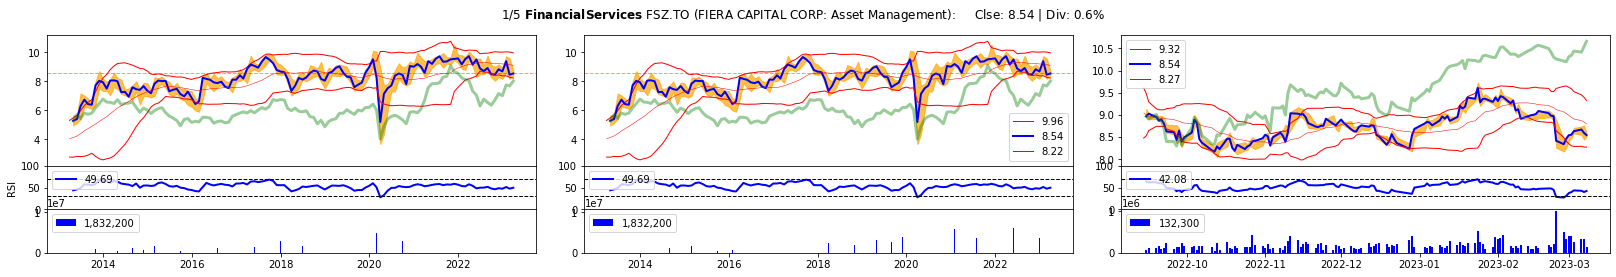

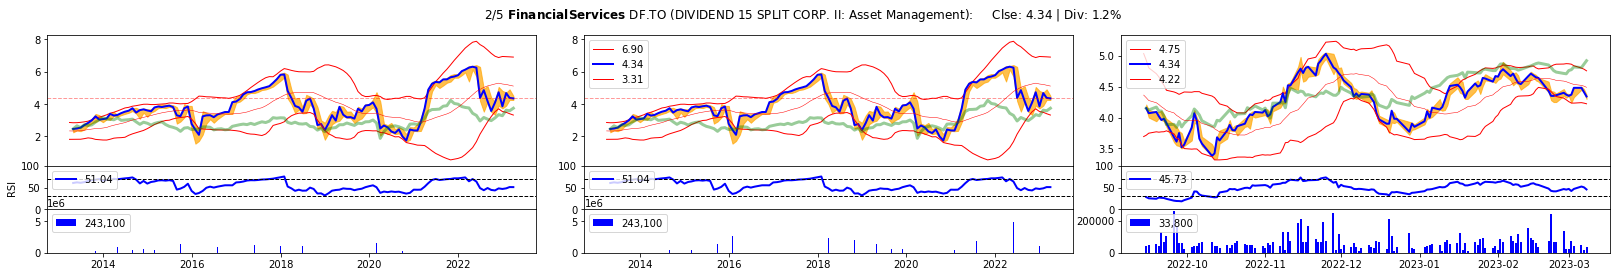

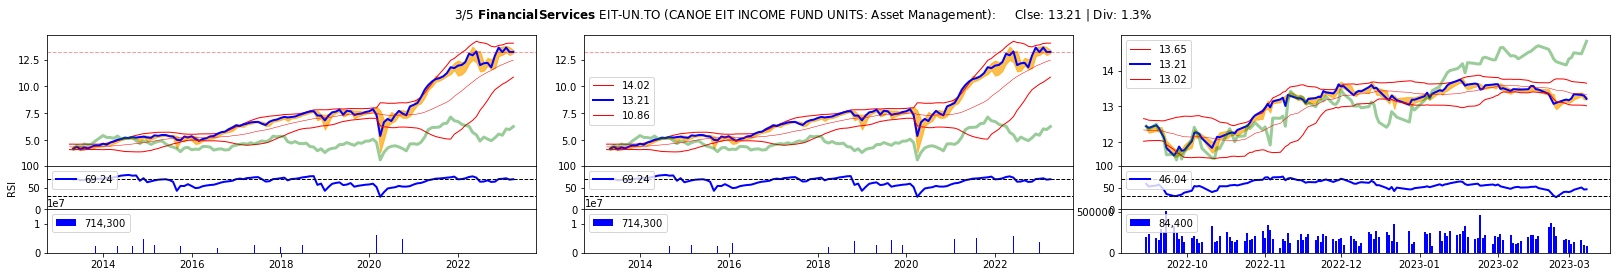

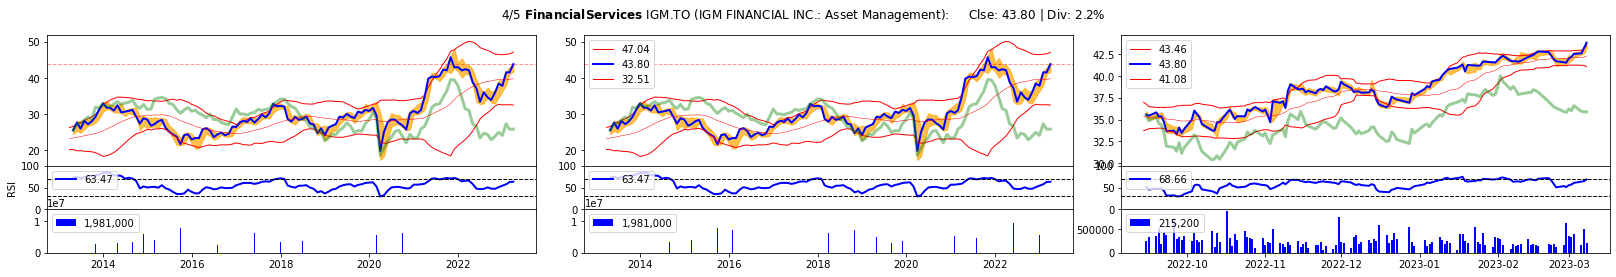

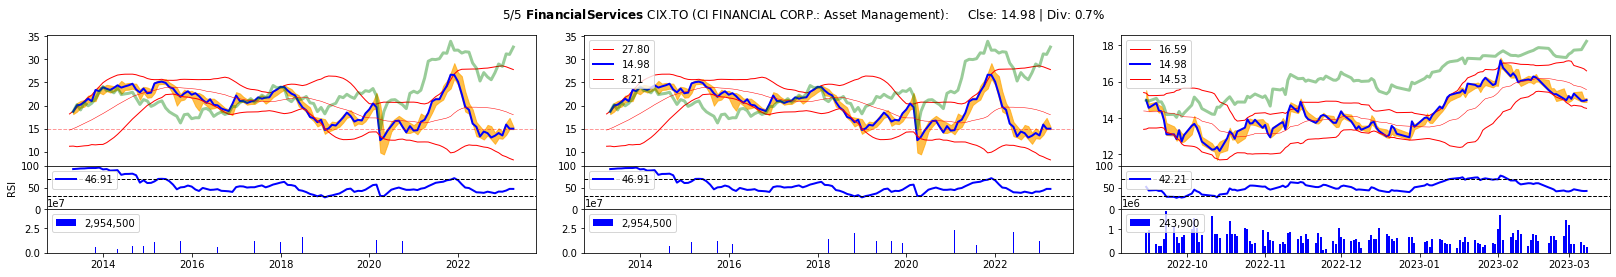

In [84]:
ticks2print = []

# for key in all:
# for key in ['mylist']:
# for key in ['Buy']:

# for key in ['Industrials']:
for key in ['Financial Services']:
# for key in ['Basic Materials']:
# for key in ['Consumer Cyclical']:
# for key in ['Consumer Defensive']:
# for key in ['Utilities']:
# for key in ['Energy']:
# for key in ['Communication Services']:
# for key in ['Technology']:

    for ticker in tlist[key]:
        if ticker not in tickers_set: break
#         if bollinger_turn(ticker)['dly']:
#         if bollinger_turn(ticker)['wkly']:
#         if bollinger_turn(ticker)['mly']:
#         if bollinger_cont(ticker)['dly']:
#         if get_rsi(df3, 15)[-1]<30:
        if True:
            ticks2print.append(ticker)

count=0
total = len(ticks2print)
# for ticker in tlist['mylist']:
for ticker in ticks2print:
    df1 = mly[ticker].iloc[-last-rate:]
    df2 = mly[ticker].iloc[-last-rate:]
    df3 = dly[ticker].iloc[-last-rate:]
    dfs=[df1,df2,df3]
    count=count+1
    plott(count, total, dfs, last, rate, ticker)    

# Creating New Plott with sector in the background

In [39]:
def plott2(count, total, dfs, last, rate, ticker):
    fig = plt.figure(figsize=(29,4))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0)
    gs = fig.add_gridspec(5, 3)
    dicts = [mly, wkly, dly]

    ax1 = fig.add_subplot(gs[:3, 0])
    ax2 = fig.add_subplot(gs[:3, 1])
    ax3 = fig.add_subplot(gs[:3, 2])
    ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)
    ax5 = fig.add_subplot(gs[3, 1], sharex=ax2)
    ax6 = fig.add_subplot(gs[3, 2], sharex=ax3)
    ax7 = fig.add_subplot(gs[4, 0], sharex=ax1)
    ax8 = fig.add_subplot(gs[4, 1], sharex=ax2)
    ax9 = fig.add_subplot(gs[4, 2], sharex=ax3)
    axs=(ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9)
#     i=1
#     print(len(dfs[i][-last:].Close), len(get_aggr(ticker, dicts[i], last, tick_groups)))
    
    for i in [0,1,2]:
        axs[i].plot(get_bol_upper(dfs[i].Close, rate), 'r', label='Bollinger Upper', linewidth=1)[-last:]
        axs[i].plot(dfs[i][-last:].Close, 'b', label='Close', linewidth=2)
        if len([1 for v in tick_groups.values() if ticker in v])>0:
            axs[i].plot(get_aggr(ticker, dicts[i], last, tick_groups), 'g', label='ref', linewidth=3, alpha=0.4)
        axs[i].plot(get_bol_lower(dfs[i].Close, rate), 'r', label='Bollinger Lower', linewidth=1)[-last:]
        axs[i].plot(get_sma(dfs[i].Close, rate), 'r', label='SMA', linewidth=0.5)

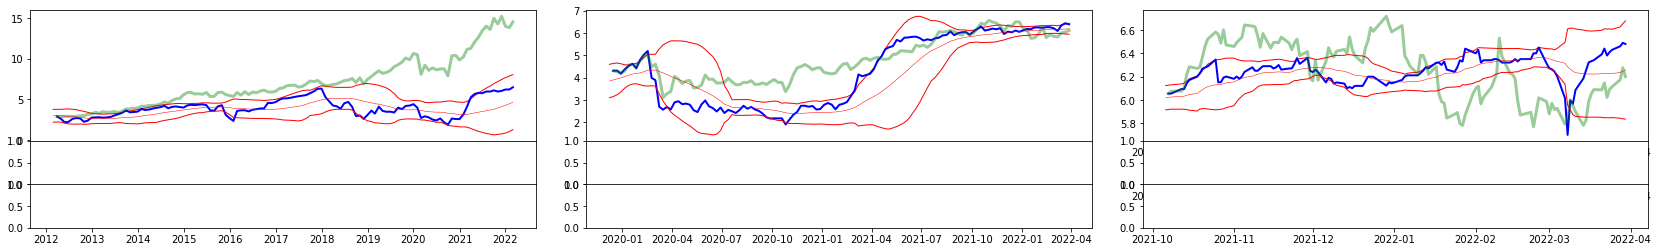

In [46]:
ticker='DF.TO'
df1 = mly[ticker].iloc[-last-rate:]
df2 = wkly[ticker].iloc[-last-rate:]
df3 = dly[ticker].iloc[-last-rate:]
dfs=[df1,df2,df3]
plott2(1,1,dfs,last,rate,ticker)

In [59]:
get_aggr('ERO.TO', mly, last, tick_groups)

Date
2022-03-01    13.790612
2022-02-01    12.111327
2022-01-01    10.254914
2021-12-01     9.857481
2021-11-01     9.026765
2021-10-01     9.413224
2021-09-01     7.932313
2021-08-01     8.746552
2021-07-01     9.087276
2021-06-01     9.509021
2021-05-01     9.986640
2021-04-01     9.826391
2021-03-01     8.438689
2021-02-01     9.402898
2021-01-01     7.257582
2020-12-01     7.751596
2020-11-01     6.380010
2020-10-01     5.229424
2020-09-01     4.342822
2020-08-01     4.818762
2020-07-01     4.154508
2020-06-01     3.941879
2020-05-01     3.175076
2020-04-01     3.132040
2020-03-01     2.586435
2020-02-01     3.502320
2020-01-01     3.713690
2019-12-01     4.559554
2019-11-01     4.054104
2019-10-01     3.731429
2019-09-01     3.736996
2019-08-01     2.976170
2019-07-01     4.112934
2019-06-01     4.712356
2019-05-01     3.939042
2019-04-01     5.370229
2019-03-01     5.651760
2019-02-01     5.694142
2019-01-01     5.603874
2018-12-01     4.523803
2018-11-01     4.898747
2018-10-01 

In [29]:
ticker='ERO.TO'
len([1 for v in tick_groups.values() if ticker in v])>0

True

In [17]:
ticks_df[ticks_df.industry.str.contains('Steel')]

,symbol,sector,industry,shortName,volume,currentPrice
109,STLC.TO,Basic Materials,Steel,STELCO HOLDINGS INC,493892,56.99
175,LIF.TO,Basic Materials,Steel,LABRADOR IRON ORE ROYALTY CORPO,191304,42.05
268,CIA.TO,Basic Materials,Steel,CHAMPION IRON LIMITED,331597,6.64


0. clean up extra days in wkly and mly datasets
1. compute prev wk, m for each day
2. add boll bands upper, lower, mid and rsi to wkly and mly
3. merge dly, wkly, mly with prev wk, m for each day, bring close, boll bands, rsi
4. add flags m close above, close to upper, above mid, below mid, close to lower, below lower, rsi segment (0, 30, 40, 50, 60, 70, 100)

In [15]:
# for ticker in set(tlist['Financial Services']):
#     t = yf.Ticker(ticker)
#     dly[ticker] = t.history(period='max', interval='1d').dropna()
#     wkly[ticker] = t.history(period='max', interval='1wk').dropna()
#     mly[ticker] = t.history(period='max', interval='1mo').dropna()
#     print('{} done'.format(ticker))

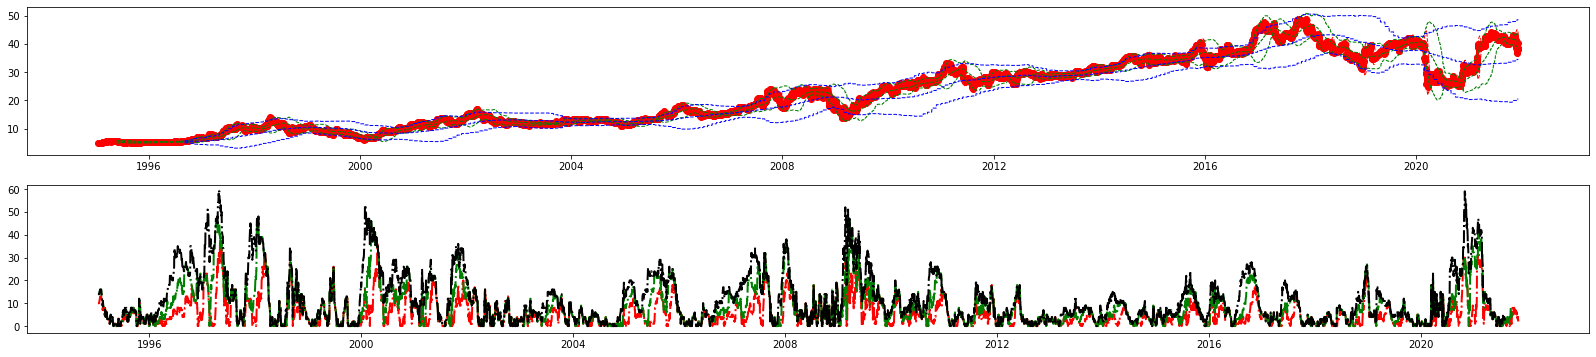

In [122]:
ticker = 'LB.TO'
dfd = dly[ticker].copy()
dfd['wkstart']=dfd.index.map(lambda x: x - datetime.timedelta(x.weekday()))
dfd['mstart']=dfd.index.map(lambda x: x - datetime.timedelta(x.day-1))
dfd['dc'] = dfd.Close
dfd['dbu'] = get_bol_upper(dfd.Close, 20)
dfd['dbl'] = get_bol_lower(dfd.Close, 20)
dfd['dsma'] = get_sma(dfd.Close, 20)
dfd['drsi'] = get_rsi(dfd.Close, 15)
dfd = dfd[['wkstart','mstart','dc','dbu','dsma','dbl','drsi']]

dfw = wkly[ticker].copy()
dfw['wc'] = dfw.Close
dfw['wbu'] = get_bol_upper(dfw.Close, 20)
dfw['wbl'] = get_bol_lower(dfw.Close, 20)
dfw['wsma'] = get_sma(dfw.Close, 20)
dfw['wrsi'] = get_rsi(dfw.Close, 15)
dfw = dfw[['wc','wbu','wbl','wsma','wrsi']]

dfm = mly[ticker].copy()
dfm['mc'] = dfm.Close
dfm['mbu'] = get_bol_upper(dfm.Close, 20)
dfm['mbl'] = get_bol_lower(dfm.Close, 20)
dfm['msma'] = get_sma(dfm.Close, 20)
dfm['mrsi'] = get_rsi(dfm.Close, 15)
dfm = dfm[['mc','mbu','mbl','msma','mrsi']]

df = dfd.merge(dfw, how='left', left_on='wkstart', right_index=True).merge(dfm, how='left', left_on='mstart', right_index=True)
df['m30'] = round((df.iloc[::-1].dc.rolling(30).max().iloc[::-1] / df.dc - 1) *100)
df['m60'] = round((df.iloc[::-1].dc.rolling(60).max().iloc[::-1] / df.dc - 1) *100)
df['m90'] = round((df.iloc[::-1].dc.rolling(90).max().iloc[::-1] / df.dc - 1) *100)

df['dpos'] = round((df.dc - df.dbl) / (df.dbu-df.dbl) *10)
df['wpos'] = round((df.wc - df.wbl) / (df.wbu-df.wbl) *10)
df['mpos'] = round((df.mc - df.mbl) / (df.mbu-df.mbl) *10)
df['dposf'] = ((df.dc - df.dbl) / (df.dbu-df.dbl) *10)
df['wposf'] = ((df.wc - df.wbl) / (df.wbu-df.wbl) *10)
df['mposf'] = ((df.mc - df.mbl) / (df.mbu-df.mbl) *10)


i=-8000
fig = plt.figure(figsize=(28,6))
ax1 = fig.add_subplot(211)
plt.plot(df[i:].dc, 'o-r', lw=3)
plt.plot(df[i:].dbu, c='red', ls='--', lw=1)
plt.plot(df[i:].dbl, c='red', ls='--', lw=1)
plt.plot(df[i:].dsma, c='red', ls='--', lw=1)

# plt.plot(df[i:].wc, 'xg', lw=2)
plt.plot(df[i:].wbu, c='green', ls='--', lw=1)
plt.plot(df[i:].wbl, c='green', ls='--', lw=1)
plt.plot(df[i:].wsma, c='green', ls='--', lw=1)

# plt.plot(df[i:].mc, 'xb', lw=1)
plt.plot(df[i:].mbu, c='blue', ls='--', lw=1)
plt.plot(df[i:].mbl, c='blue', ls='--', lw=1)
plt.plot(df[i:].msma, c='blue', ls='--', lw=1)

ax2 = fig.add_subplot(212)
plt.plot(df[i:].m30, c='red', ls='-.', lw=2)
plt.plot(df[i:].m60, c='green', ls='-.', lw=2)
plt.plot(df[i:].m90, c='black', ls='-.', lw=2)

In [29]:
df2 = df[['dpos','wpos','mpos','buy_st']].copy().dropna()
df3 = df2.groupby(by=['mpos','wpos','dpos']).mean('buy_st').reset_index()
df3.head()

df3[df3.mpos==0].pivot(index='dpos', columns='wpos', values='buy_st')

import seaborn as sns
fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4, figsize=(15,6), sharex=False)
axs=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]
for x in range(0,8):
    sns.heatmap(df3[df3.mpos==(x-1)].pivot(index='dpos', columns='wpos', values='buy_st'), ax=axs[x])
    axs[x].set_title(x-1)
    axs[x].invert_yaxis()
fig.tight_layout()

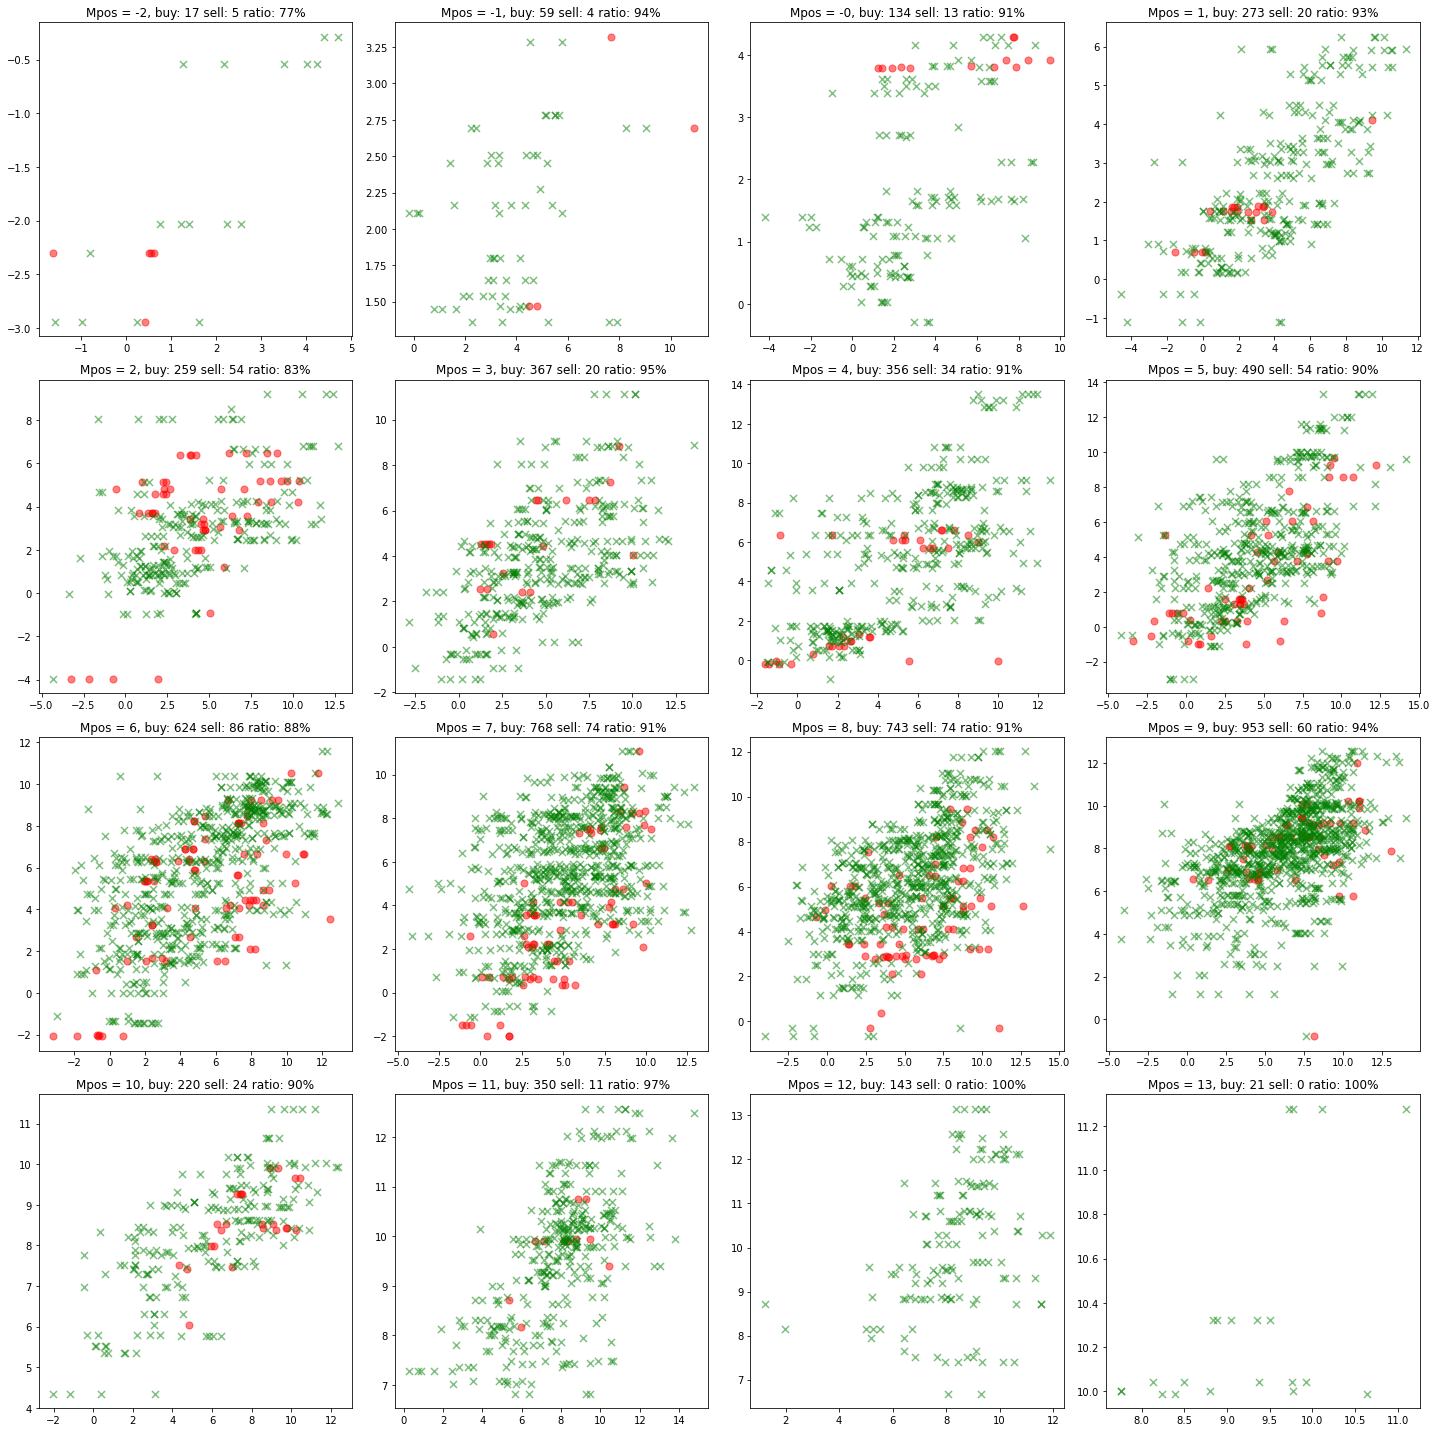

In [128]:
import warnings
warnings.filterwarnings(action='ignore')

price_target=1
df['buy_st']=df.m30.apply(lambda x: 1 if x>=price_target else 0)
df['buy_mt']=df.m60.apply(lambda x: 1 if x>=price_target else 0)
df['buy_lt']=df.m90.apply(lambda x: 1 if x>=price_target else 0)

mpos_vals = list(sorted(df.mpos.dropna().unique()))
mpos_len = mpos_vals.__len__()
# fig, ((s1,s2,s3,s4),(s5,s6,s7,s8),(s9,s10,s11,s12),(s13,s14,s15,s16)) = plt.subplots(4,4, figsize=(8,8))
fig, subs = plt.subplots(4,4, figsize=(20,20))
subs = subs.reshape(1,16)[0]

for x, ax in zip(mpos_vals, subs):
    X1=df[df.mpos==x][df.buy_lt==0].dposf
    X2=df[df.mpos==x][df.buy_lt==0].wposf
    y=df[df.mpos==x][df.buy_lt==0].buy_mt
    zeros=y.size
    ax.scatter(X1, X2, c='r', marker='o', alpha=0.5, s=50)
    X1=df[df.mpos==x][df.buy_lt==1].dposf
    X2=df[df.mpos==x][df.buy_lt==1].wposf
    y=df[df.mpos==x][df.buy_lt==1].buy_mt
    ones=y.size
    ax.scatter(X1, X2, c='g', marker='x', alpha=0.5, s=50)
    ax.set_title('Mpos = {:.0f}, buy: {} sell: {} ratio: {:.0%}'.format(x, ones, zeros, ones/(ones+zeros)))
plt.tight_layout();